<a id="2"></a>
# <p style="padding:10px;background-color:#00a6ed ;margin:0;color:#ffffff;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Import Libraries </p>

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image , ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import cv2 
import random
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader , Dataset
import torchvision.utils as vutils 
import torch.optim as optim
from torch.autograd import Variable

<a id="2"></a>
# <p style="padding:10px;background-color:#00a6ed ;margin:0;color:#ffffff;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Import Dataset </p>

In [2]:
def imports(img_dir):
    img = []
    label = []

    for subfolder in os.listdir(img_dir):
        subfolder_path = os.path.join(img_dir, subfolder)

        for img_filename in os.listdir(subfolder_path):
            img_path =os.path.join(subfolder_path,img_filename)

            img.append(img_path)

            label.append(subfolder)
    return img,label

In [ ]:
train_dir = './archive/Train'
img,label = imports(train_dir)
train_df = pd.DataFrame({'img':img ,'label':label })

test_dir = './archive/Test'
img,label = imports(test_dir)
test_df = pd.DataFrame({'img':img ,'label':label })

df = pd.concat([train_df,test_df], axis=0)
df 

,img,label
0,./archive/Train\class_0\image_0.jpg,class_0
1,./archive/Train\class_0\image_1.jpg,class_0
2,./archive/Train\class_0\image_10.jpg,class_0
3,./archive/Train\class_0\image_100.jpg,class_0
4,./archive/Train\class_0\image_1000.jpg,class_0
...,...,...
49995,./archive/Test\class_9\image_14995.jpg,class_9
49996,./archive/Test\class_9\image_14996.jpg,class_9
49997,./archive/Test\class_9\image_14997.jpg,class_9
49998,./archive/Test\class_9\image_14998.jpg,class_9


In [4]:
df['label'] = df['label'].str.split('_').str[1]
df['label'] = df['label'].astype(int)
df

,img,label
0,./archive/Train\class_0\image_0.jpg,0
1,./archive/Train\class_0\image_1.jpg,0
2,./archive/Train\class_0\image_10.jpg,0
3,./archive/Train\class_0\image_100.jpg,0
4,./archive/Train\class_0\image_1000.jpg,0
...,...,...
49995,./archive/Test\class_9\image_14995.jpg,9
49996,./archive/Test\class_9\image_14996.jpg,9
49997,./archive/Test\class_9\image_14997.jpg,9
49998,./archive/Test\class_9\image_14998.jpg,9


In [5]:
df_1 = df.groupby('label').sample(n=5000, random_state=42)
df_1

,img,label
1499,./archive/Test\class_0\image_11499.jpg,0
6475,./archive/Train\class_0\image_6826.jpg,0
3167,./archive/Test\class_0\image_13167.jpg,0
862,./archive/Train\class_0\image_1774.jpg,0
5970,./archive/Train\class_0\image_6371.jpg,0
...,...,...
47784,./archive/Test\class_9\image_12784.jpg,9
95558,./archive/Train\class_9\image_600.jpg,9
99319,./archive/Train\class_9\image_9386.jpg,9
46598,./archive/Test\class_9\image_11598.jpg,9


In [6]:
df_1.describe()

,label
count,50000.00000
mean,4.50000
std,2.87231
min,0.00000
25%,2.00000
50%,4.50000
75%,7.00000
max,9.00000


In [7]:
df_counts = df_1['label'].value_counts()
df_counts

label
0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: count, dtype: int64

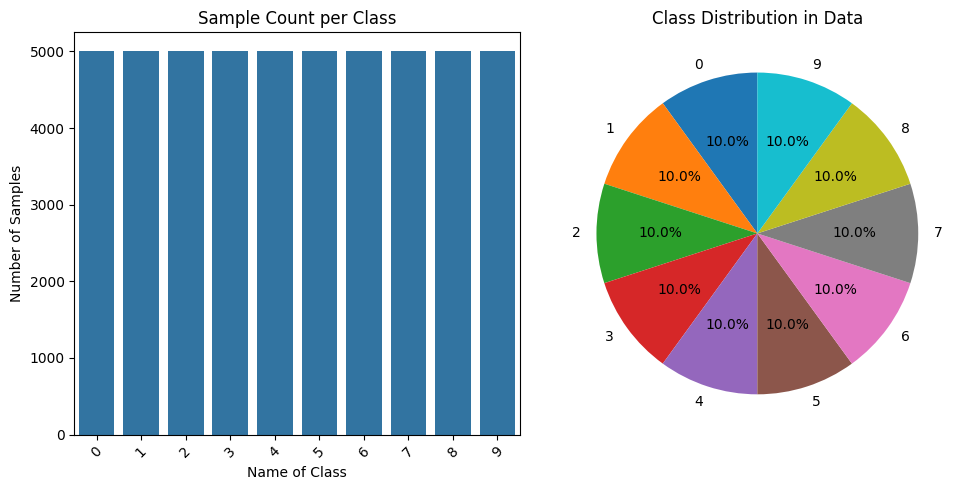

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 

df_1['label'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    ax=axes[1],  
    legend=False
)
axes[1].set_ylabel('')  
axes[1].set_title('Class Distribution in Data')

sns.countplot(x='label', data=df_1, ax=axes[0])
axes[0].set_xlabel('Name of Class')
axes[0].set_ylabel('Number of Samples')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_title('Sample Count per Class')


plt.tight_layout()
plt.show()

In [9]:
#all the images has a same size
image = plt.imread(df_1.iloc[random.randrange(len(df_1))]['img'])   

height, width= image.shape[:2]

print("The height is ", height)

print("The width is ", width)

The height is  28
The width is  28


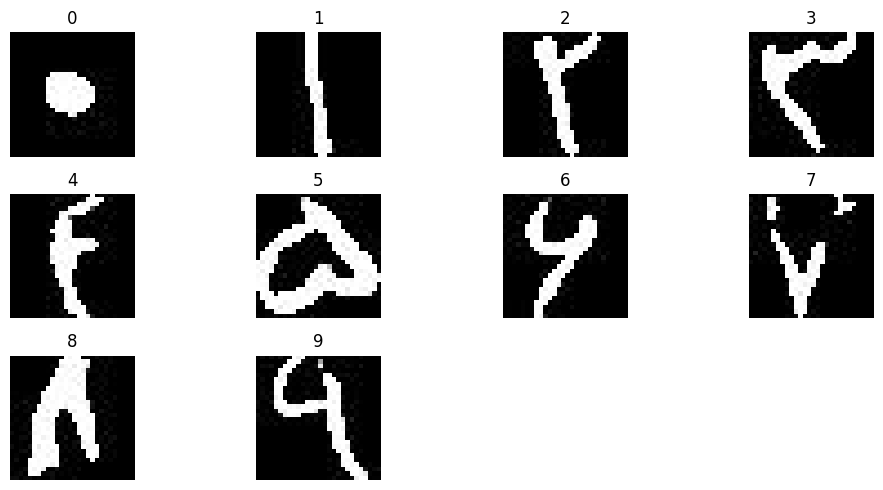

In [10]:
df_unique = df_1.groupby('label', as_index=False).first()

plt.figure(figsize=(10, 5))
for i in range(10):
    img_path = df_unique.loc[i, 'img']
    label = df_unique.loc[i, 'label']
    
    img = plt.imread(img_path)
    plt.subplot(3, 4, i + 1)
    plt.imshow(img ,cmap='gray')
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

<div style="border: 3px solid none; background-color: #00a6ed;
            font-family: 'Times New Roman';
            font-size: 140%; padding: 15px;
            color: white; font-weight: bold; line-height: 1.6;">

  <div style="font-size: 170%; margin-bottom: 8px;"> Data Loader </div>
</div>

<div style="border: 3px solid none; background-color: #C4C3D0;
            font-family: 'Times New Roman';
            font-size: 110%; padding: 10px;
            color: black;">

The DataLoader is a PyTorch utility that helps you efficiently load your dataset in mini-batches during training or testing.

It takes a dataset (like a custom Dataset class or a built-in one like MNIST) and gives you an iterator that returns batches of data.

In [11]:
#This class actually comes in and converts all our images to the grayscale format that pytorch understands and turns them into tensors.
class MyImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['img']
        label = self.dataframe.iloc[idx]['label']
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        image = Image.open(img_path).convert('L')  
        
        if self.transform:
            image = self.transform(image)
        
        return image, label_tensor

In [12]:
transform = transforms.Compose([ 
    transforms.Grayscale(num_output_channels=1), 
    transforms.ToTensor(),        
    transforms.Normalize(mean=[0.5],  
                         std=[0.5])
])

In [13]:
#Dataloader is a class for PyTorch data loading utility. It is used to import data from datasets.

dataset_ = MyImageDataset(df_1, transform=transform)
data_loader = DataLoader(dataset_, batch_size=100, shuffle=True)
data_loader

In [14]:
img, label = next(iter(data_loader))
print(img.shape, label)

torch.Size([100, 1, 28, 28]) tensor([3, 6, 5, 2, 1, 1, 1, 3, 3, 4, 6, 7, 8, 4, 7, 6, 5, 4, 1, 5, 1, 5, 7, 2,
        3, 0, 1, 1, 5, 8, 3, 6, 0, 0, 0, 0, 7, 2, 0, 8, 1, 2, 0, 0, 7, 5, 8, 7,
        8, 4, 2, 0, 2, 6, 2, 1, 7, 9, 2, 9, 4, 2, 5, 9, 4, 5, 7, 7, 7, 4, 5, 0,
        8, 7, 0, 6, 4, 9, 6, 8, 6, 0, 2, 8, 2, 3, 8, 3, 5, 2, 3, 3, 0, 2, 1, 1,
        9, 4, 5, 2])


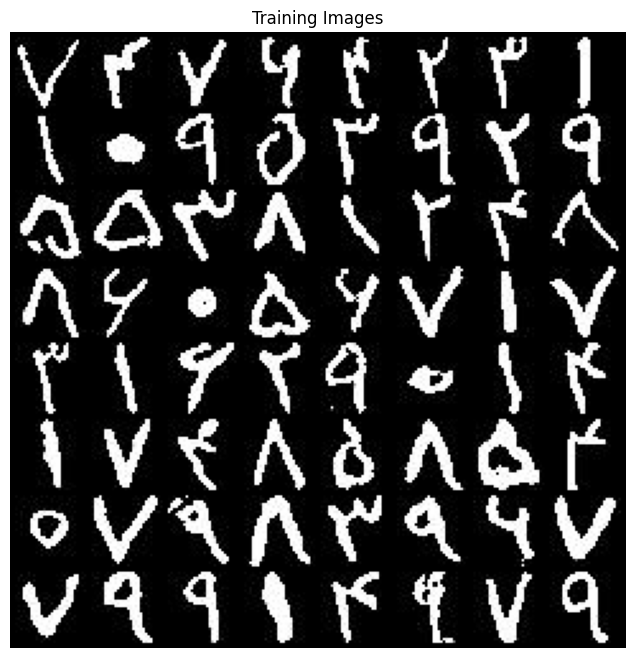

In [15]:
real_batch = next(iter(data_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

<a id="2"></a>
# <p style="padding:10px;background-color:#00a6ed ;margin:0;color:#ffffff;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Device of Process </p>

In [16]:
# for moving data into GPU (if available)
def get_device():
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
device = get_device()
device

device(type='cuda', index=0)

<a id="2"></a>
# <p style="padding:10px;background-color:#00a6ed ;margin:0;color:#ffffff;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"> MY Model </p>

![](https://media.geeksforgeeks.org/wp-content/uploads/20231117113724/Conditional-GANs.png)

<div style="border: 3px solid none; background-color: #C4C3D0;
            font-family: 'Times New Roman';
            font-size: 110%; padding: 10px;
            color: black;">

Hyperparameter

In [18]:
# Size of z latent vector (i.e. size of generator input) for numericals between 50:100
nz = 100

# Number of training epochs
num_epochs = 80

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

batch_size = 100

num_classes = 10

In [19]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

<div style="border: 3px solid none; background-color: #C4C3D0;
            font-family: 'Times New Roman';
            font-size: 110%; padding: 10px;
            color: black;">

Generator Model

In [20]:
class Generator(nn.Module):
  def __init__(self, n=256):
    super(Generator, self).__init__()

    self.fc1 = nn.LazyLinear(n)
    self.fc2 = nn.LazyLinear(n*2)
    self.fc3 = nn.LazyLinear(n*4)
    self.fc4 = nn.LazyLinear(28*28)

  def forward(self, img, labels):

    labels = F.one_hot(labels, num_classes=10)
    x = torch.cat([img, labels], dim=1)

    x = F.leaky_relu(self.fc1(x), 0.2)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = F.leaky_relu(self.fc3(x), 0.2)
    out = torch.tanh(self.fc4(x))

    return out

 - 1 = [0 ,1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0]
 - 6 = [0 ,0 ,0 ,0 ,0 ,0 ,1 ,0 ,0 ,0]
 - 0 = [1 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0 ,0]

<div style="border: 3px solid none; background-color: #C4C3D0;
            font-family: 'Times New Roman';
            font-size: 110%; padding: 10px;
            color: black;">

Discriminator Model

In [21]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.fc1 = nn.LazyLinear(1024)
    self.fc2 = nn.LazyLinear(512)
    self.fc3 = nn.LazyLinear(256)
    self.fc4 = nn.LazyLinear(1)

  def forward(self, img, labels):

    labels = F.one_hot(labels, num_classes=10)
    x = torch.cat([img, labels], dim=1)

    x = F.dropout(F.leaky_relu(self.fc1(x), 0.2), 0.3)
    x = F.dropout(F.leaky_relu(self.fc2(x), 0.2), 0.3)
    x = F.dropout(F.leaky_relu(self.fc3(x), 0.2), 0.3)
    out = torch.sigmoid(self.fc4(x))

    return out

<div style="border: 3px solid none; background-color: #C4C3D0;
            font-family: 'Times New Roman';
            font-size: 110%; padding: 10px;
            color: black;">

Build Models

In [22]:
#Gen
Gen = Generator().to(device)
Gen

c:\Users\LavaN-32428068\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Generator(
  (fc1): LazyLinear(in_features=0, out_features=256, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=512, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=1024, bias=True)
  (fc4): LazyLinear(in_features=0, out_features=784, bias=True)
)

In [23]:
#Disc
Disc = Discriminator().to(device)
Disc

Discriminator(
  (fc1): LazyLinear(in_features=0, out_features=1024, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=512, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=256, bias=True)
  (fc4): LazyLinear(in_features=0, out_features=1, bias=True)
)

In [24]:
loss_fn = nn.BCELoss()

In [25]:
G_optimizer = optim.Adam(Gen.parameters() , lr=lr)
D_optimizer = optim.Adam(Disc.parameters(), lr=lr)

In [26]:
loss_D_hist, loss_G_hist = [], []

In [27]:
for imgs, labels in data_loader:
    print(imgs.shape)  # [batch_size, channels, height, width]
    break

torch.Size([100, 1, 28, 28])


In [ ]:
for epoch in range(num_epochs):
  loss_D_avg, loss_G_avg = AverageMeter(), AverageMeter()
  
  for real_img, real_label in data_loader:
    # noise & fake label
    noise = torch.randn(batch_size,100).to(device)            #([0,1,2,5,6,...,0],[1,2,5,8,...,5],....,[0,2,4,7,...,1])
    fake_labels = torch.randint(0, 10, (batch_size,)).to(device)
    generated_data = Gen(noise, fake_labels) # batch_size X 784
    #----------------------------------------------------------------------
    # Discriminator
    #----------------------------------------------------------------------
    Disc.zero_grad()

    # real data
    real_data = real_img.view(batch_size, 784).to(device)      # 784 = 1*64*64
    digit_labels = real_label.to(device) # batch_size
    real_labels = torch.ones(batch_size, 1).to(device)

    # real,digit_labels -> D
    D_output = Disc(real_data, digit_labels)
    real_discriminator_loss = loss_fn(D_output, real_labels)



    # (generated data, fake_labels) -> D
    discriminator_output_for_generated_data = Disc(generated_data, fake_labels)

    generator_discriminator_loss = loss_fn(discriminator_output_for_generated_data, torch.zeros(batch_size, 1).to(device))

    discriminator_loss = (real_discriminator_loss + generator_discriminator_loss) / 2

    # optimization And backward
    discriminator_loss.backward()
    D_optimizer.step()

    #----------------------------------------------------------------------
    # Generator
    #----------------------------------------------------------------------
    Gen.zero_grad()
    # noise, fake_labels > G
    noise = torch.randn(batch_size, 100).to(device)
    real_labels = torch.ones(batch_size, 1).to(device)
    generated_data = Gen(noise, fake_labels)

    # generated_data,fake_labels -> D
    discriminator_output_on_generated_data = Disc(generated_data, fake_labels)

    # loss
    G_loss = loss_fn(discriminator_output_on_generated_data, real_labels)

    # optimization And backward
    G_loss.backward()
    G_optimizer.step()

    loss_D_avg.update(discriminator_loss.item())
    loss_G_avg.update(G_loss.item())

  loss_D_hist.append(loss_D_avg.avg)
  loss_G_hist.append(loss_G_avg.avg)

  print(f'{epoch+1}/{num_epochs}: D Loss: {loss_D_avg.avg:.4f}, G Loss: {loss_G_avg.avg:.4f}')

1/80: D Loss: 0.2847, G Loss: 3.2187
2/80: D Loss: 0.2859, G Loss: 3.2356
3/80: D Loss: 0.2159, G Loss: 3.5846
4/80: D Loss: 0.1856, G Loss: 3.6626
5/80: D Loss: 0.1781, G Loss: 4.0692
6/80: D Loss: 0.2008, G Loss: 3.4969
7/80: D Loss: 0.1854, G Loss: 3.7794
8/80: D Loss: 0.1911, G Loss: 3.5011
9/80: D Loss: 0.2302, G Loss: 3.3048
10/80: D Loss: 0.2263, G Loss: 3.2322
11/80: D Loss: 0.2516, G Loss: 2.9484
12/80: D Loss: 0.2970, G Loss: 2.7092
13/80: D Loss: 0.3299, G Loss: 2.3768
14/80: D Loss: 0.3191, G Loss: 2.3986
15/80: D Loss: 0.3067, G Loss: 2.5133
16/80: D Loss: 0.3205, G Loss: 2.4130
17/80: D Loss: 0.3285, G Loss: 2.3713
18/80: D Loss: 0.3449, G Loss: 2.2688
19/80: D Loss: 0.3497, G Loss: 2.1922
20/80: D Loss: 0.3812, G Loss: 2.0391
21/80: D Loss: 0.3987, G Loss: 1.9538
22/80: D Loss: 0.4097, G Loss: 1.8853
23/80: D Loss: 0.4345, G Loss: 1.7488
24/80: D Loss: 0.4396, G Loss: 1.6594
25/80: D Loss: 0.4451, G Loss: 1.6593
26/80: D Loss: 0.4510, G Loss: 1.6366
27/80: D Loss: 0.4618

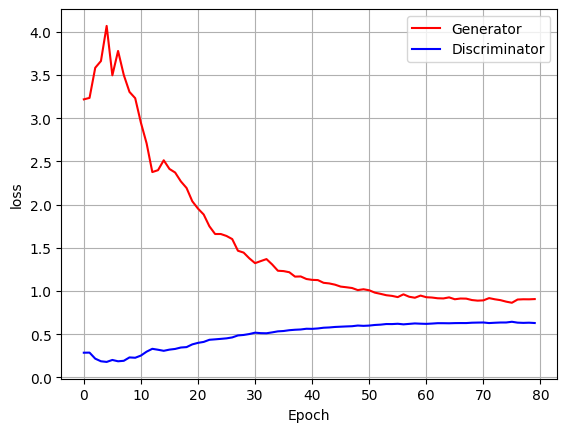

In [30]:
plt.plot(range(num_epochs), loss_G_hist, 'red', label='Generator')
plt.plot(range(num_epochs), loss_D_hist, 'blue', label='Discriminator')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
torch.save(Gen, './weights/generator.pt')

In [ ]:
generator_model = torch.load('./weights/generator.pt')


with torch.no_grad():
  bs = 5
  test_z = torch.randn(bs, 100).to(device)
  label = torch.tensor([3,4, 9, 7, 8]).to(device)
  outputs = generator_model(test_z, label)
  vutils.save_image(outputs.view(bs, 1, 28, 28), './output/gan_output5.png')

(-0.5, 151.5, 31.5, -0.5)

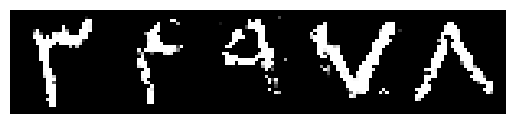

In [38]:
plt.imshow(mpimg.imread('./output/gan_output5.png'))
plt.axis('off')

<a id="2"></a> <br>
<span class="label label-default" style="background-color:#00a6ed; border-radius:12px; font-weight: bold; font-family:Verdana; font-size:24px; color:#FBFAFC; "> About Me</span>

 **<font color=#00a6ed	 style='font-size: 18px; font-weight: bold;' >Author : Yasin Neyestani </font>**

<br>

[![GitHub](https://img.shields.io/badge/GitHub-Profile-00a6ed?logo=github)](https://github.com/YasinNeyestanii)


[![LinkedIn](https://img.shields.io/badge/LinkedIn-Profile-00a6ed?logo=linkedin)](https://www.linkedin.com/in/yasin-neyestani/)


[![Kaggle](https://img.shields.io/badge/Kaggle-Profile-00a6ed?logo=Kaggle)](https://www.kaggle.com/imyasin/)

<br>